## STA 141A: Assignment 3
### Jiawei Zhu 923312684



## Random seeds


In [1]:
set.seed(1)

## Question 1 


Consider an exponential distribution $X \sim \text{Exponential}(\text{rate} = 1).$


For sample sizes $n = 20, 50, 200$, conduct simulation studies with 5,000 replicates as follows. 

1. Simulate the sampling distribution of the $10\%$ trimmed mean (`mean( , trim=0.1)`).
2. Plot the sampling distributions of the trimmed means for each $n$. 
3. Compute the empirical standard error of the trimmed means for each $n$.
4. Compare the standard error of the trimmed mean to that of the ordinary mean and comment on your findings, if any.


# A tibble: 3 × 6
      n Mean_trim StandardError_trim Mean_mean StandardError_mean
  <dbl>     <dbl>              <dbl>     <dbl>              <dbl>
1    20     0.856             0.207      1.00              0.226 
2    50     0.840             0.128      1.000             0.143 
3   200     0.834             0.0649     1.00              0.0701
# ℹ 1 more variable: ratio_SE_trim_over_mean <dbl>


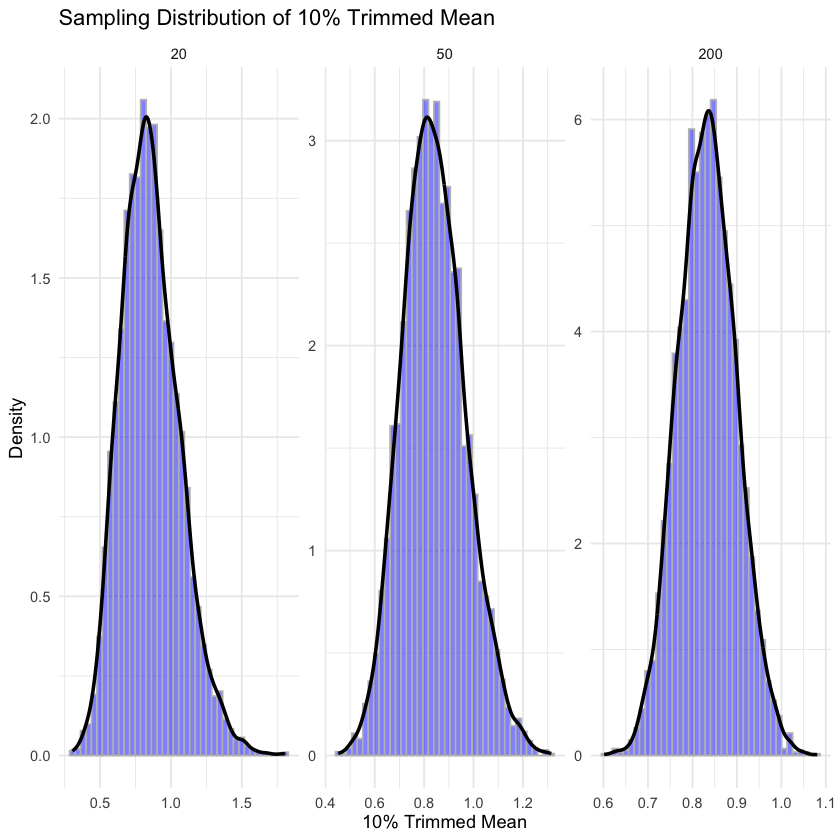

In [ ]:
# 1 (1)
library(tidyverse)
set.seed(1)

sampling_distribution_stat <- function(rfun, n, reps, stat_fun) {
  out <- numeric(reps)
  for (i in seq_len(reps)) {
    s <- rfun(n)
    out[i] <- stat_fun(s)
  }
  out
}

r_skewed   <- function(n) rexp(n, rate = 1) 
sizes <- c(20, 50, 200)
reps <- 5000

sampling_dist_10 <- lapply(sizes, function(n) {
  sampling_distribution_stat(r_skewed,
   n,
   reps,
     stat_fun = function(x) mean(x, trim = 0.1))
})

names(sampling_dist_10) <- paste0("n_", sizes)  

trimmed_means_df <- lapply(sizes, function(n) {
  sampling_distribution_stat(r_skewed,
   n,
    reps,
     stat_fun = mean)
}) 

names(trimmed_means_df) <- paste0("n_", sizes)

# 1 (2)
sample_trimmed <- map2_dfr(sampling_dist_10,sizes,~tibble(
  sample_size = .y,
  trimmed_mean = .x
))

ggplot(sample_trimmed, aes(x = trimmed_mean)) +
  geom_histogram(aes(y = after_stat(density)), bins = 40, fill = "blue", color = "grey", alpha = 0.5) +
  geom_density(color = "black", linewidth = 1) +
  facet_wrap(~ sample_size, scales = "free") +
  labs(title = "Sampling Distribution of 10% Trimmed Mean",
       x = "10% Trimmed Mean",
       y = "Density") +
  theme_minimal( )


# 1 (3)

standard_error_trim <- map_dbl(sampling_dist_10, sd)

# 1 (4)
standard_error_mean <- map_dbl(trimmed_means_df, sd)

summary_tbl <- tibble(
  n = sizes,
  Mean_trim = map_dbl(sampling_dist_10, mean),
  StandardError_trim   = standard_error_trim,
  Mean_mean = map_dbl(trimmed_means_df, mean),
  StandardError_mean   = standard_error_mean,
  ratio_SE_trim_over_mean = standard_error_trim / standard_error_mean
)

print(summary_tbl)

## Question 2


Consider a standard normal distribution $X \sim N(0, 1)$.

For sample sizes $n = 10, 50, 200$, conduct the simulation studies with 5000 replicates as follows. 

1. Simulate the sampling distribution of the sample variance $S^2$.
2. Plot the sampling distribution of the sample variance for each $n$. 
3. Compute the empirical means of $S^2$ and compare them to the population variance.
4. Comment on any apparent bias and on the shape of the sampling distribution.


# A tibble: 3 × 4
      n Emperical_Mean pop_variance Theoretical_Mean_mean
  <dbl>          <dbl>        <dbl>                 <dbl>
1    20           1.01            1                 0.958
2    50           1.00            1                 0.981
3   200           1.00            1                 0.996


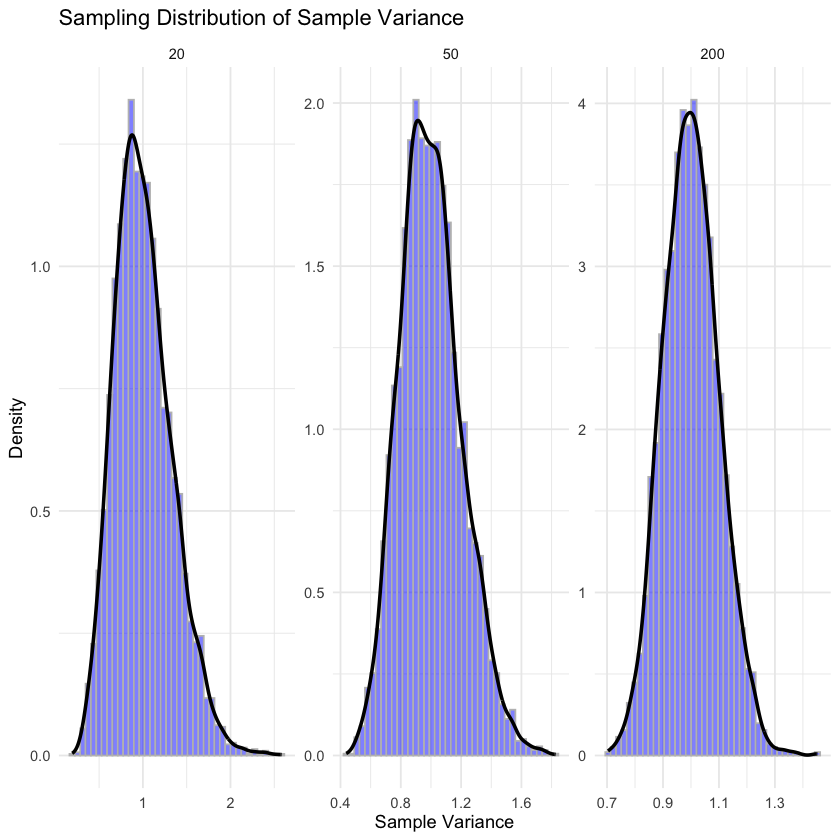

In [ ]:
# 2（1）
library(tidyverse)
set.seed(1)

sampling_distribution_stat <- function(rfun, n, reps, stat_fun) {
  out <- numeric(reps)
  for (i in seq_len(reps)) {
    s <- rfun(n)
    out[i] <- stat_fun(s)
  }
  out
}
r_normal   <- function(n) rnorm(n, mean = 0, sd = 1)

q2_size <- c(20, 50, 200)
reps <- 5000

sampling_dist_variance <- lapply(q2_size, function(n) {
  sampling_distribution_stat(r_normal,
   n,
   reps,
     stat_fun = var)
})
names(sampling_dist_variance) <- paste0("n_", q2_size)


# 2（2）
sample_variance <- map2_dfr(sampling_dist_variance,q2_size,~tibble(
  sample_size = .y,
  sample_variance = .x
))

ggplot(sample_variance, aes(x = sample_variance)) +
  geom_histogram(aes(y = after_stat(density)), bins = 40, fill = "blue", color = "grey", alpha = 0.5) +
  geom_density(color = "black", linewidth = 1) +
  facet_wrap(~ sample_size, scales = "free") +
  labs(title = "Sampling Distribution of Sample Variance",
       x = "Sample Variance",
       y = "Density") +
  theme_minimal( )


# 2（3）
emperical_variance_means <- map_dbl(sampling_dist_variance, mean)

summary_means_tbl <- tibble(
  n = q2_size,
  Emperical_Mean = emperical_variance_means,
  pop_variance = 1,
  Theoretical_Mean_mean= Emperical_Mean * (q2_size - 1) / (q2_size)
)

print(summary_means_tbl)


### Question 2 (4)

The sampling distribution of S^2 is determined by the n. In the first graph (n = 20), it is right-skewed. With the n increasing (n=50,n=200), the sampling distribution become more close to the symmetric. And because the emperical means are 0.958, 0.981 and 0.996. They are very close to each others so that there is no or little bias. 

## Question 3

Consider an exponential distribution $X \sim \text{Exponential}(1)$. Let $q$ be the 75th percentile of the population.  For $n = 10, 50, 200$, estimate $P(\bar{X} > q)$ using Monte Carlo simulation. 

In [6]:
# 3
library(tidyverse)
set.seed(1)


r_exp <- function(n) rexp(n, rate = 1)
size3 <- c(10, 50, 200)
quartile_75 <- qexp(0.75, rate = 1)

mc_prob <- function(rfun, n,reps = 5000, threshold) {
  xbar <- replicate(reps, mean(rfun(n)))
  mean(xbar > threshold)
}

for (n in size3) {
  cat("n =", n, ": P(xbar > ", quartile_75, ") ≈", mc_prob(r_exp, n, threshold = quartile_75), "\n")
}



n = 10 : P(xbar >  1.386294 ) ≈ 0.1192 
n = 50 : P(xbar >  1.386294 ) ≈ 0.0044 
n = 200 : P(xbar >  1.386294 ) ≈ 0 


## Question 4

Consider the Student $t$-distribution with 3 degrees of freedom $X \sim t(3)$. 

1. Draw a single sample of size $n = 100$.
2. Construct a *bootstrap distribution* of the sample mean using $B = 4000$ resamples.
3. Simulate the sampling distribution of the mean using the Monte Carlo method. 
4. Compare the standard error of the mean from bootstrap and Monte Carlo method.

In [7]:
# 4 (1)
library(tidyverse)
set.seed(1)

n <- 100
r_t3 <- rt(n, df = 3)

r_t3


[1] -0.702721075 -0.569319568  0.684276620 -0.362001217 -0.213010346
  [6]  0.692591467 -0.461397142 -0.013471498  0.775500933  0.809099700
 [11]  0.057708964  2.031693760 -0.484388736  1.754190437 -0.583432182
 [16]  0.942996257 -0.324888560 -0.182084486  0.887750497  1.039883102
 [21] -1.213503310  1.149728603  0.702575514 -1.001569301  2.970990351
 [26] -7.397511302  3.000233623 -0.239413879  2.371008769  0.294624373
 [31]  0.020787041 -0.845234541 -1.340097842 -0.542619556  0.129103875
 [36]  1.108119101 -0.341356518  0.266252673 -0.314383750  0.448895190
 [41]  0.018321922  1.519231148 -2.191717753  0.877479401 -1.374777813
 [46]  0.287710301 -0.865322906 -0.333429059 -0.983215228  2.600126859
 [51]  2.931791578 -0.274111287 -0.290734157 -2.187316799 -0.090470469
 [56] -0.091825515 -0.002597269 -0.416459210 -0.887124825 -0.517896362
 [61]  0.590884237  1.410006435  0.556528885  2.008078406 -0.544613232
 [66] -2.472145496  0.515259893  0.898254928 -0.360625902 -1.085456625
 [71] -0.635875167 -1.333978426 -0.113436626 -2.080530798  0.784494732
 [76] -1.010797469  1.011175186 -0.102746267 -1.004102295 -1.244446017
 [81]  3.825974136 -3.108338176  0.026831111 -0.387416438  1.153429748
 [86] -0.285035380  0.096892816 -1.123323902  2.201081504  5.527557428
 [91] -2.120490061 -0.930611792 -1.948019179 -1.789869097  0.415192989
 [96]  0.329018201 -0.493536065 -0.004835109  1.139221318 -0.680496176

In [14]:
# 4 (2)
Value_B <- 4000

bootstrap_mean <- numeric(Value_B)

  for (b in 1:Value_B) {
    x_sample <- sample(r_t3, size = n, replace = TRUE)
    bootstrap_mean[b] <- mean(x_sample)
  }

bootstrap_mean


[1]  1.172583e-01  5.478559e-02 -5.903023e-02 -1.333493e-01 -1.278103e-01
   [6] -1.381432e-01  2.871670e-01  2.464384e-02  1.221361e-01  6.472771e-04
  [11]  3.285938e-02  1.195634e-01 -5.757093e-02 -2.048500e-01  2.086230e-01
  [16] -3.968750e-03 -1.613857e-01  7.839769e-02  1.160192e-01  1.946401e-01
  [21] -1.741655e-01  2.718133e-01 -7.981118e-02  1.899684e-01  5.583240e-02
  [26] -2.074599e-01  2.999389e-01  4.408140e-02  8.888767e-02  1.326632e-01
  [31]  1.339763e-01  8.313007e-02  6.397528e-02  5.380521e-02 -8.084965e-02
  [36] -4.278870e-02 -3.459615e-01  8.015594e-03  8.609075e-02  2.691879e-01
  [41]  3.624132e-02 -2.551417e-01 -1.908690e-01 -2.888631e-02 -1.274616e-01
  [46]  2.334972e-02 -5.277283e-01  2.980607e-01  5.662521e-01 -2.391186e-01
  [51]  5.536219e-02 -1.401026e-02  1.508957e-02 -1.543040e-02 -6.035651e-02
  [56]  8.854266e-02 -1.045250e-01 -4.088794e-02 -9.053963e-03 -1.315758e-01
  [61]  7.705532e-02 -1.812650e-01 -1.007286e-01 -3.938004e-02  7.519683e-03
  [66] -2.353903e-01  2.429449e-01  2.143768e-01  5.573795e-03 -3.372132e-02
  [71] -7.647145e-02  9.332111e-02  2.395967e-01  1.979080e-01 -3.018754e-03
  [76]  1.014110e-01 -1.599140e-01  1.746789e-01  9.830127e-02 -2.218799e-02
  [81]  2.411963e-01 -2.619031e-01  2.565415e-01 -1.034974e-01 -5.473020e-02
  [86] -1.658681e-01 -2.992918e-02 -3.737643e-02  9.690890e-02 -1.398477e-01
  [91]  7.586738e-02  1.537870e-01  5.168543e-02  5.808979e-02  4.386479e-01
  [96] -6.939382e-02 -5.416019e-02 -1.295370e-02 -2.385012e-01 -1.062211e-01
 [101] -4.151810e-02 -5.580916e-02 -1.465167e-01  1.503902e-01 -1.007961e-02
 [106] -7.888227e-03  4.963215e-02  1.072302e-01 -1.646383e-01  1.435995e-01
 [111] -7.049482e-02 -7.934969e-02 -5.399236e-02  9.620051e-02  1.314731e-01
 [116] -4.825658e-04  1.958663e-01  1.060146e-01 -1.714718e-01 -2.552784e-02
 [121] -2.954390e-02 -3.438767e-01  8.819982e-02  8.655454e-02 -3.690727e-02
 [126] -2.311097e-02  1.850422e-02 -1.467882e-01 -9.161574e-03 -2.960699e-02
 [131] -3.294062e-01  3.467562e-02  1.955586e-01  3.292968e-02  2.742359e-01
 [136] -2.094598e-02 -1.725048e-01  1.300244e-02 -2.994877e-01 -1.323196e-01
 [141] -3.364238e-01  1.172481e-01  1.343625e-01  6.352838e-02 -9.112207e-02
 [146]  2.818083e-02 -1.384308e-01  7.773089e-02  1.897816e-01 -6.806472e-02
 [151]  7.574851e-02  7.811918e-03 -1.645641e-01  1.285476e-01  1.333583e-01
 [156]  1.063354e-01 -1.680489e-02 -6.570440e-02  4.134064e-01 -1.381262e-01
 [161]  2.167831e-01  7.367067e-02  9.195203e-02 -1.115505e-01  2.338012e-01
 [166]  1.686055e-01  1.132489e-01  1.198514e-01 -1.360125e-01  2.369908e-01
 [171]  1.994236e-01 -3.935532e-02 -3.691192e-01 -7.634554e-04  2.662744e-01
 [176]  3.241194e-02  1.472428e-01  1.192795e-01  2.147463e-01 -2.892009e-01
 [181]  2.775839e-02  2.005255e-01 -3.277848e-02  4.696736e-02 -4.807607e-02
 [186] -2.644227e-01  3.151384e-01  6.893408e-02  8.422212e-02  3.632651e-02
 [191] -8.926881e-02 -1.669576e-02  1.688810e-01 -2.847436e-01 -1.589296e-01
 [196]  1.842552e-01 -1.122472e-01  2.310888e-01 -7.928047e-02  7.138999e-02
 [201]  1.035424e-01  1.100603e-01  1.524916e-01  1.002566e-01 -3.411130e-01
 [206]  2.690677e-01  5.021406e-02 -1.160975e-01  3.136920e-02 -1.949872e-01
 [211] -1.342180e-01 -1.075751e-01 -4.323635e-02  2.001492e-01 -1.018969e-01
 [216] -7.607074e-02 -6.115925e-03  2.430951e-02 -6.759529e-02  2.659313e-01
 [221]  8.640907e-03  2.619069e-03  1.192653e-01 -4.668878e-02  8.485184e-02
 [226]  1.573631e-01 -2.198747e-01  1.974277e-01  3.298999e-03  5.323968e-02
 [231]  5.734990e-02 -2.920576e-01 -1.366322e-01  1.339636e-01  5.771798e-03
 [236]  9.354875e-02  1.103733e-01  6.085263e-02  5.431642e-02 -2.541492e-01
 [241] -1.470811e-01  1.065851e-01  1.852276e-01 -1.139108e-01  2.154123e-01
 [246]  1.356832e-01  1.193604e-02 -2.354979e-01  3.910757e-02 -1.700740e-01
 [251]  6.671458e-02  2.080940e-01  1.239044e-01 -8.744110e-02  6.144096e-02
 [256]  1.906555e-01  7.953059e-02 -2.682118e-02 -3.512397e-01  1.964570e-01

In [13]:
# 4 (3)
montecarlo_means <- numeric(Value_B)

for (b in 1:Value_B) {
  s <- rt(n, df = 3)
  montecarlo_means[b] <- mean(s)
}

montecarlo_means

[1]  1.151270e-01 -1.113151e-01  9.748729e-02  1.528690e-01 -1.502927e-01
   [6]  7.366045e-02 -9.790925e-02 -7.842850e-02  1.524279e-02 -1.252670e-01
  [11] -1.183576e-01 -4.416451e-01 -3.517452e-01 -8.677763e-02  4.891637e-02
  [16]  5.020346e-02  2.218132e-01  4.015900e-01  1.028214e-01  5.171466e-01
  [21]  5.314713e-02 -1.188172e-01 -1.391265e-01  1.598473e-01 -4.220154e-02
  [26] -1.486704e-01  4.192679e-02  1.532593e-01  2.179375e-01  1.544022e-01
  [31] -2.102573e-01 -2.560588e-02  8.754562e-02 -7.439366e-02  5.104158e-02
  [36]  2.344705e-02 -2.235978e-01 -3.956102e-02  2.358977e-02  1.377758e-01
  [41] -1.674525e-01 -1.841168e-01  7.453737e-02 -4.976078e-02 -1.578085e-01
  [46]  2.056502e-01  2.512499e-01  1.440847e-01  4.018458e-01  2.800822e-01
  [51] -2.926925e-01 -6.419309e-02  1.789285e-01 -1.178274e-01 -1.273505e-01
  [56]  1.271174e-01 -5.702348e-02  3.706111e-02  5.302703e-02  1.019222e-01
  [61] -6.785508e-02 -4.606486e-02 -1.771752e-01 -9.273727e-02 -1.386341e-01
  [66] -2.422834e-01 -3.706381e-02 -2.310568e-01  3.877423e-01  2.062508e-01
  [71] -7.969347e-02 -6.152764e-02  1.854061e-01  1.339941e-01  2.267807e-01
  [76] -2.543561e-01 -5.326018e-02  3.531729e-02  8.633069e-02  4.895519e-02
  [81]  1.835981e-01  2.135822e-02 -1.263279e-01 -2.950850e-02  1.295823e-01
  [86] -2.707765e-01 -2.007332e-01  1.190565e-01  2.988182e-01 -1.843239e-01
  [91] -5.688774e-02  8.844516e-02 -2.286186e-01 -4.159866e-02 -2.180252e-01
  [96]  1.214388e-01 -5.162772e-02  1.721054e-01 -8.641427e-02  2.527760e-02
 [101] -2.284214e-01 -1.582219e-02  2.530281e-01  1.066720e-01 -1.230626e-01
 [106]  4.537251e-02  4.949373e-02 -1.875875e-01  1.397110e-01  1.458273e-01
 [111]  8.389945e-02 -1.093314e-01  4.721358e-02  3.488845e-01 -9.610693e-02
 [116]  1.289412e-01  4.955275e-04  1.227728e-01  1.318901e-01  1.471099e-01
 [121]  1.851045e-01  3.504042e-02 -9.713735e-03  1.444662e-01 -1.272480e-01
 [126]  9.584416e-02  9.732296e-04 -2.189798e-01  7.025710e-02  8.994764e-02
 [131]  5.581282e-01 -3.146025e-01 -3.444101e-01  2.397771e-02  1.248094e-02
 [136]  3.130344e-01 -5.804556e-02 -2.468007e-01 -1.544373e-01  7.090696e-02
 [141] -2.111288e-01 -1.860219e-01 -8.214129e-02  6.745469e-02 -1.865356e-01
 [146]  1.159480e-01  1.629711e-01 -6.872796e-02 -1.572894e-01  2.095438e-01
 [151] -3.509279e-02  6.897894e-02  1.096220e-01 -2.147743e-01  1.169348e-01
 [156]  1.093367e-01  2.957447e-02  1.032768e-01 -2.176500e-02 -2.472442e-01
 [161]  9.398936e-02 -8.730762e-02  3.079801e-02 -4.926731e-02 -6.999166e-02
 [166]  7.469982e-03  7.554157e-02 -1.312598e-01 -4.845243e-01  1.916481e-01
 [171] -2.767787e-02 -3.472123e-01  1.400593e-01  7.111678e-02  9.989328e-02
 [176] -2.026040e-02 -4.634800e-02 -1.794733e-01  1.846233e-01 -2.038381e-01
 [181]  3.591853e-01 -2.057523e-01 -1.780769e-01 -9.797072e-02 -2.697585e-02
 [186] -9.839595e-02  1.634177e-01 -1.306375e-01  2.424185e-02  5.176111e-02
 [191]  2.076513e-02 -5.416253e-02  2.567605e-02 -1.483021e-01 -1.619184e-01
 [196]  3.673992e-02  3.344754e-02 -1.012762e-01  1.989974e-01 -5.051770e-02
 [201] -1.082145e-01  9.463153e-02  1.562909e-01  5.629349e-02  1.662549e-03
 [206]  1.383665e-01  4.590752e-02 -1.509183e-01  5.657514e-02  6.335988e-02
 [211]  9.397251e-02 -4.003881e-01  2.351716e-01 -1.560425e-01 -1.538387e-01
 [216] -1.016153e-01  1.591489e-01 -7.139512e-02  4.727021e-02  2.243215e-02
 [221] -2.810297e-01  5.488176e-02  5.725460e-02 -2.391609e-02  2.264910e-02
 [226]  2.592479e-02  2.654961e-02  1.755007e-01 -1.412335e-01 -4.009736e-03
 [231]  4.106921e-02  2.108629e-01 -3.803392e-02  3.851342e-02  1.774494e-01
 [236]  1.895854e-01  1.301222e-01  6.548254e-02  1.936789e-01  2.602676e-01
 [241] -1.292131e-01 -1.970866e-01 -1.357764e-01 -1.185657e-01 -1.836676e-01
 [246]  8.761944e-02 -1.188529e-01  1.204092e-01 -2.483427e-03 -8.246252e-02
 [251] -6.684292e-02  2.048934e-01  7.590463e-02 -2.027497e-01 -3.134355e-02
 [256]  1.753564e-01 -2.782412e-02  7.435787e-02 -2.844666e-01 -1.461912e-01

In [16]:

# 4 (4)
se_bootstrap <- sd(bootstrap_mean)
se_montecarlo <- sd(montecarlo_means)


cat("Bootstrap SE =", se_bootstrap, "\n")
cat("Monte Carlo SE =", se_montecarlo, "\n")

Bootstrap SE = 0.1537962 
Monte Carlo SE = 0.1718109 
